In [1]:
import os
import datetime
import time
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import numpy as np
import h5py
import scipy.io
import pandas as pd
from sklearn.decomposition import PCA
import librosa
import soundfile as sound
import keras


from sklearn.metrics import confusion_matrix

from utils import *
from funcs import *

from sklearn.metrics import log_loss

import os

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

Using TensorFlow backend.
/work/contractors/jtaylor/.conda/envs/d20-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/contractors/jtaylor/.conda/envs/d20-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/contractors/jtaylor/.conda/envs/d20-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

In [2]:
#Task 1a dev validation set
val_csv = 'evaluation_setup_v2/fold1_evaluate.csv'
feat_path = 'features/logmel128_scaled/'

# put the trained model path here
# model_path = 'pretrained_models/10class-resnet-model-0.7458.hdf5'
# model_path = 'pretrained_models/10class-fcnn-model-0.7694.hdf5'
model_path = 'pretrained_models/10class-fsfcnn-model-0.7620.hdf5'

dev_test_df = pd.read_csv(val_csv,sep='\t', encoding='ASCII')
wav_paths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])

for idx, elem in enumerate(wav_paths):
    wav_paths[idx] = wav_paths[idx].split('/')[-1].split('.')[0]
    wav_paths[idx] = wav_paths[idx].split('-')[-1]

device_idxs = wav_paths
device_list = np.unique(device_idxs) 
print(device_list)

num_freq_bin = 128
num_classes = 10


# get results for each device
data_val, y_val = load_data_2020(feat_path, val_csv, num_freq_bin, 'logmel')
data_deltas_val = deltas(data_val)
data_deltas_deltas_val = deltas(data_deltas_val)
data_val = np.concatenate((data_val[:,:,4:-4,:],data_deltas_val[:,:,2:-2,:],data_deltas_deltas_val),axis=-1)
y_val_onehot = keras.utils.np_utils.to_categorical(y_val, num_classes)


best_model = keras.models.load_model(model_path)

['a' 'b' 'c' 's1' 's2' 's3' 's4' 's5' 's6']







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
#best_model.summary()

layer_name = 'global_average_pooling2d_2'
intermediate_layer_model = keras.Model(inputs=best_model.input, outputs=best_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data_val)


In [4]:
print(intermediate_output[0], intermediate_output[1], intermediate_output[-1])

[ 1.8427308  -0.3749648  -0.47835854 -0.47427025 -0.4798716  -0.31320357
  0.17397915  0.3883741  -0.37789807 -0.47920603] [ 0.83438605 -0.47242635 -0.48313838 -0.40173784 -0.38446757  0.51426274
 -0.28371003  0.7861896  -0.32821494 -0.30846494] [-0.18743058  0.45547202  0.42875192 -0.4280723  -0.44250363 -0.29569694
 -0.44508442 -0.328954   -0.4777779   1.2021526 ]


In [6]:
pca2 = PCA(2)
pca2.fit(intermediate_output)
embeddings2 = pca2.transform(intermediate_output)
print(embeddings2)

print(y_val)

[[ 0.20172784  1.431285  ]
 [ 0.3575761   0.8970242 ]
 [ 0.3206774   1.0939381 ]
 ...
 [-1.4473484  -0.915892  ]
 [-0.7841624  -0.7407695 ]
 [-1.3658105  -0.66109586]]
[0 0 0 ... 9 9 9]


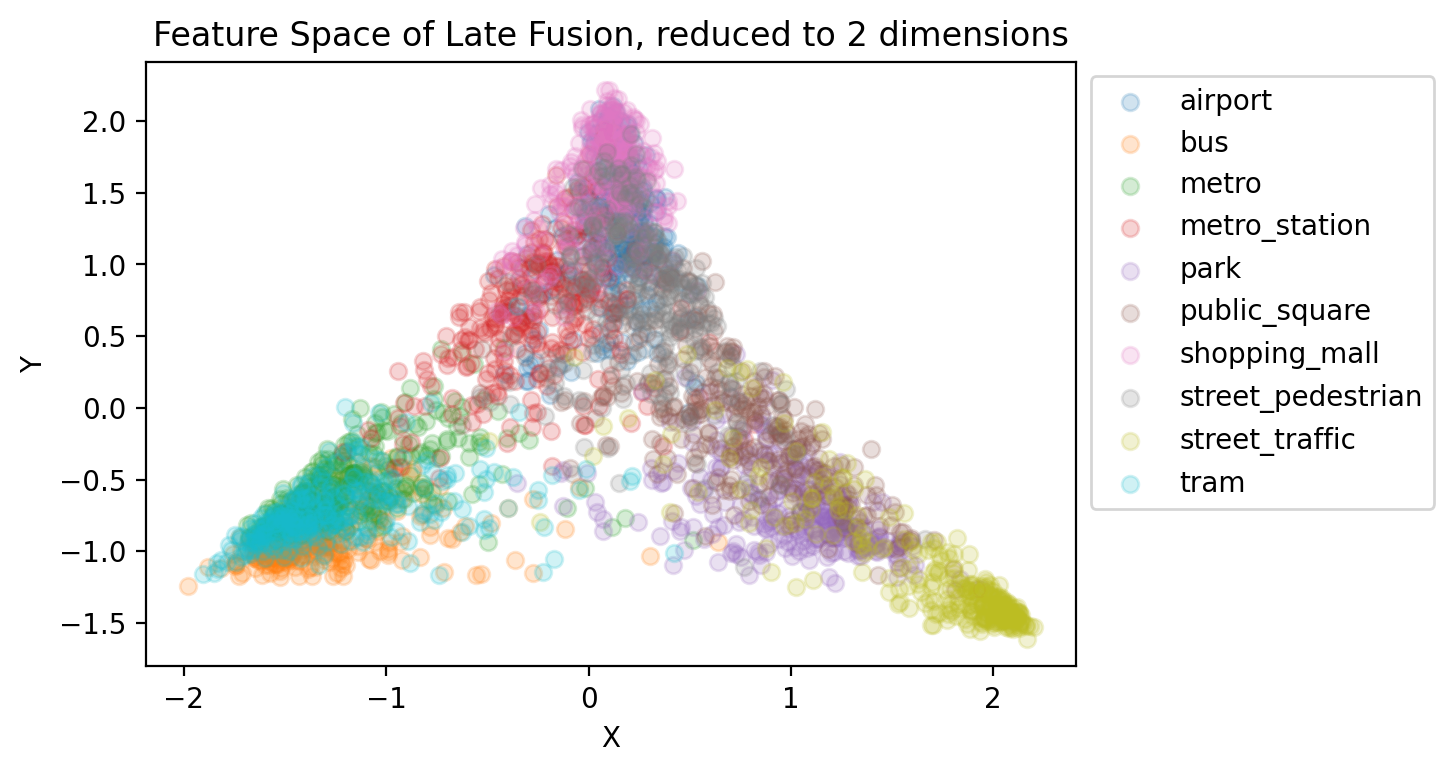

In [7]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

data = embeddings2
ids = y_val

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

plt.figure(dpi=200)
#plt.figure(figsize=(60,18))

for i in range(10):
    class_data = embeddings2[ids == i]
    plt.scatter(class_data[:, 0], class_data[:, 1], color=color_list[i], alpha=0.2, label=ClassNames[i])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Feature Space of Late Fusion, reduced to 2 dimensions')

# Create custom legend handler to make legend elements fully opaque
def custom_legend_handler(legend, orig_handle, color):
    new_handle = mpatches.Patch(facecolor=color, edgecolor='none', alpha=1)
    return new_handle

# Add legend with custom handler
plt.legend(handler_map={plt.scatter: custom_legend_handler},loc='upper right', bbox_to_anchor=(1.4, 1))

# Show the plot
plt.show()

In [8]:
pca3 = PCA(3)
pca3.fit(intermediate_output)
embeddings3 = pca3.transform(intermediate_output)
print(embeddings3)

[[ 0.20171791  1.4312863  -0.1484549 ]
 [ 0.35757017  0.8970263   0.14259961]
 [ 0.3206701   1.0939399   0.23514536]
 ...
 [-1.4473414  -0.91590154  0.01410878]
 [-0.78415656 -0.7407751   0.56385547]
 [-1.3658056  -0.6611049  -0.08615901]]


[0 1 2 3 4 5 6 7 8 9]
['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:

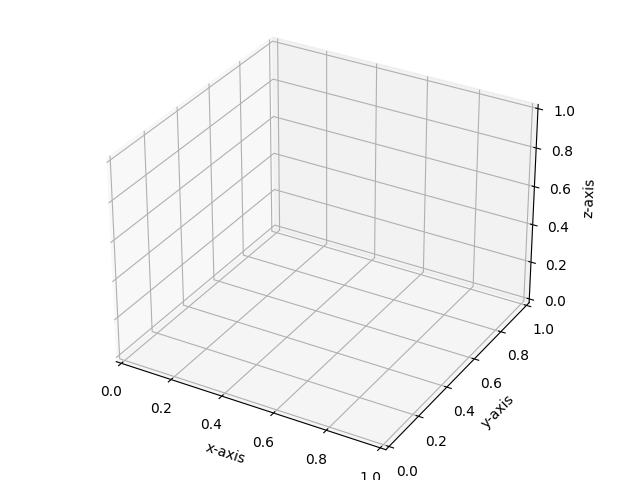

In [ ]:
data = embeddings3
ids = y_val
# creating 3d plot using matplotlib 
# in python
 
# for creating a responsive plot
%matplotlib widget
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
 
indices = np.random.choice(len(data), size=1000, replace=False)

# Extract x, y, and z coordinates from the sampled indices
x = data[indices, 0]
y = data[indices, 1]
z = data[indices, 2]

# Extract IDs for the sampled indices
sampled_ids = [ids[i] for i in indices]

# Map IDs to colors using the colormap
color_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
colors = [color_list[i] for i in sampled_ids]

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
 
# creating the plot
#plot_geeks = 
# ax.scatter(x, y, z, c='green')
# ax.scatter(x-1, y-1, z-1, c='blue')
 
unique_ids = np.unique(sampled_ids)
print(unique_ids)

for i, unique_id in enumerate(unique_ids):
    # Select data points for the current ID
    id_mask = sampled_ids == unique_id
    x_id = x[id_mask]
    y_id = y[id_mask]
    z_id = z[id_mask]

    # Plot the data points with color-coding
    print(color_list[unique_id])
    colors_id = [color for color, mask in zip(colors, id_mask) if mask]
    print(colors_id)
    #ax.scatter(x_id, y_id, z_id, c=colors_id, label=ClassNames[unique_id], alpha=0.3)

# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
 
# displaying the plot
plt.show()

[5, 6, 0, 9, 4, 5, 9, 6, 4, 3, 5, 7, 5, 5, 2, 6, 3, 0, 4, 0, 0, 2, 8, 6, 8, 1, 9, 9, 9, 6, 3, 7, 7, 2, 9, 5, 5, 1, 4, 1, 9, 5, 4, 7, 5, 6, 4, 0, 0, 6, 7, 6, 1, 5, 3, 9, 8, 6, 3, 0, 5, 5, 5, 0, 0, 1, 3, 3, 8, 6, 6, 0, 6, 7, 5, 8, 3, 9, 7, 5, 7, 1, 4, 4, 7, 3, 1, 2, 5, 3, 9, 7, 0, 7, 3, 8, 1, 7, 4, 7, 5, 1, 8, 6, 1, 9, 6, 0, 2, 4, 1, 1, 0, 0, 0, 7, 7, 2, 0, 9, 3, 4, 2, 9, 4, 5, 4, 6, 6, 7, 3, 9, 4, 7, 7, 7, 6, 7, 8, 9, 5, 0, 0, 8, 2, 0, 2, 5, 1, 1, 1, 8, 2, 7, 2, 6, 5, 9, 2, 8, 3, 2, 9, 1, 1, 1, 5, 8, 2, 3, 1, 4, 7, 7, 2, 9, 8, 2, 3, 3, 4, 5, 2, 0, 9, 4, 9, 5, 2, 3, 1, 4, 7, 0, 8, 5, 4, 6, 7, 8, 4, 7, 5, 3, 1, 7, 1, 6, 5, 6, 1, 4, 1, 1, 5, 7, 0, 8, 6, 9, 8, 6, 9, 9, 5, 6, 7, 0, 0, 6, 9, 6, 8, 4, 0, 8, 1, 0, 0, 5, 3, 5, 4, 1, 5, 5, 0, 7, 0, 1, 4, 7, 5, 8, 4, 2, 6, 2, 2, 5, 0, 3, 4, 5, 5, 9, 9, 3, 7, 4, 3, 3, 6, 1, 8, 9, 7, 0, 3, 7, 9, 5, 4, 6, 0, 5, 8, 5, 2, 5, 4, 7, 0, 7, 9, 5, 9, 0, 2, 1, 6, 7, 5, 9, 9, 3, 3, 8, 0, 3, 7, 3, 1, 3, 0, 6, 7, 7, 3, 1, 3, 7, 7, 7, 6, 4, 6, 1, 0, 6, 7, 8, 2, 

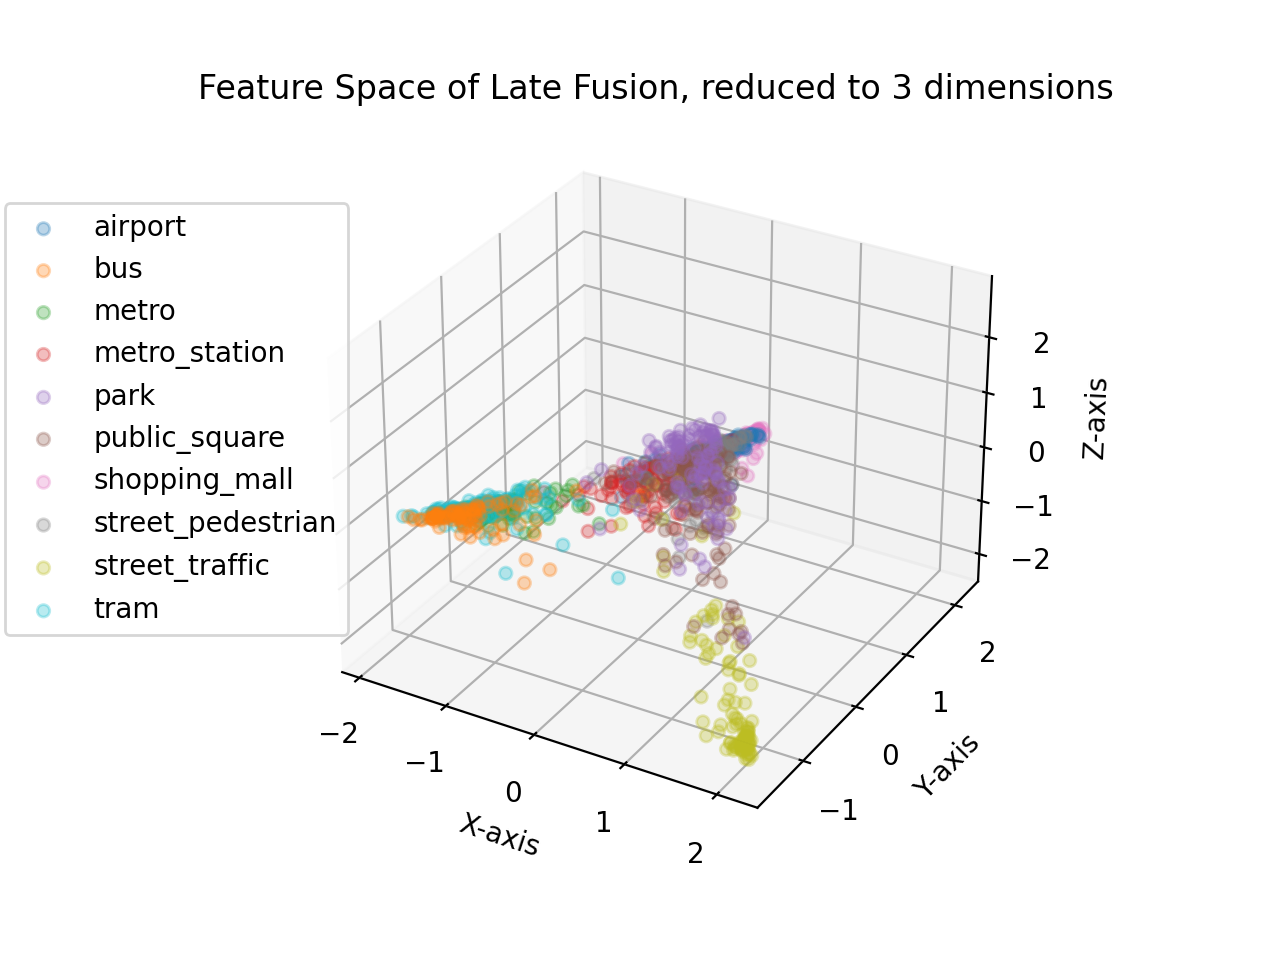

In [13]:
data = embeddings3
ids = y_val

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Assuming your numpy array is named 'data' and the ID list is named 'ids'

# Select a random sample of 100 indices
indices = np.random.choice(len(data), size=1000, replace=False)

# Extract x, y, and z coordinates from the sampled indices
x = data[indices, 0]
y = data[indices, 1]
z = data[indices, 2]

# Extract IDs for the sampled indices
sampled_ids = [ids[i] for i in indices]
print(sampled_ids)


# Map IDs to colors using the colormap
color_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
colors = [color_list[i] for i in sampled_ids]

# Create a 3D scatter plot

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot for each unique ID
unique_ids = np.unique(sampled_ids)
for i, unique_id in enumerate(unique_ids):
    # Select data points for the current ID
    id_mask = sampled_ids == unique_id
    x_id = x[id_mask]
    y_id = y[id_mask]
    z_id = z[id_mask]
    

    # Plot the data points with color-coding
    colors_id = [color for color, mask in zip(colors, id_mask) if mask]
    ax.scatter(x_id, y_id, z_id, c=colors_id, label=ClassNames[unique_id], alpha=0.3)

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Add a title to the plot
ax.set_title('Feature Space of Late Fusion, reduced to 3 dimensions')

# Add a legend
ax.legend(bbox_to_anchor=(-.4, .9), loc='upper left')

# Show the plot
plt.show()

In [5]:
print(data_val.size)
print(data_val.shape)
print('waiting 5 seconds...')
time.sleep(5)


# Do some work here
start_time = datetime.datetime.now()

preds = best_model.predict(data_val)
y_pred_val = np.argmax(preds,axis=1)

time_difference = datetime.datetime.now() - start_time
print("Time difference:", time_difference)

over_loss = log_loss(y_val_onehot, preds)
overall_acc = np.sum(y_pred_val==y_val) / data_val.shape[0]

print(y_val_onehot.shape, preds.shape)
np.set_printoptions(precision=3)

print("\n\nVal acc: ", "{0:.3f}".format(overall_acc))
print("Val log loss:", "{0:.3f}".format(over_loss))


482098176
(2968, 128, 423, 3)
waiting 5 seconds...
Time difference: 0:00:08.604484
(2968, 10) (2968, 10)


Val acc:  0.762
Val log loss: 1.128


In [12]:
device_acc = []
device_loss = []
for device_id in device_list:
    cur_preds = np.array([preds[i] for i in range(len(device_idxs)) if device_idxs[i] == device_id])
    cur_y_pred_val = np.argmax(cur_preds,axis=1)
    cur_y_val_onehot = np.array([y_val_onehot[i] for i in range(len(device_idxs)) if device_idxs[i] == device_id])
    cur_y_val = [y_val[i] for i in range(len(device_idxs)) if device_idxs[i] == device_id]
    cur_loss = log_loss(cur_y_val_onehot, cur_preds)
    cur_acc = np.sum(cur_y_pred_val==cur_y_val) / len(cur_preds)
    
    device_acc.append(cur_acc)
    device_loss.append(cur_loss)

In [13]:
print("\n\nDevices list: ", device_list)
print("Per-device val acc : ", np.array(device_acc))
print("Device A acc: ", "{0:.3f}".format(device_acc[0]))
print("Device B & C acc: ", "{0:.3f}".format((device_acc[1] + device_acc[2]) / 2))
print("Device s1 & s2 & s3 acc: ", "{0:.3f}".format((device_acc[3] + device_acc[4] + device_acc[5]) / 3))
print("Device s4 & s5 & s6 acc: ", "{0:.3f}".format((device_acc[6] + device_acc[7] + device_acc[8]) / 3))


# get confusion matrix
conf_matrix = confusion_matrix(y_val,y_pred_val)
print("\n\nConfusion matrix:")
print(conf_matrix)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

print("Class names:", ClassNames)
print("Per-class val acc: ",recall_by_class, "\n\n")



Devices list:  ['a' 'b' 'c' 's1' 's2' 's3' 's4' 's5' 's6']
Per-device val acc :  [0.839 0.76  0.815 0.767 0.727 0.767 0.73  0.745 0.709]
Device A acc:  0.839
Device B & C acc:  0.787
Device s1 & s2 & s3 acc:  0.754
Device s4 & s5 & s6 acc:  0.728


Confusion matrix:
[[179   1   1  10   0  13  53  38   1   0]
 [  0 269  11   0   2   0   0   0   1  14]
 [  0  12 245   6   3   1   0   0   1  29]
 [  8   2  12 234   1   0  25   8   2   5]
 [  0   1   3   2 278   9   0   1   3   0]
 [  5   0   4   3  51 186   2  14  32   0]
 [ 30   0   2  10   0   2 231  21   0   1]
 [ 22   9   0  18   9  46  36 143  14   0]
 [  0   1   0   2  15  11   0   3 265   0]
 [  1  29  23   2   5   2   0   0   2 232]]
Class names: ['airport' 'bus' 'metro' 'metro_station' 'park' 'public_square'
 'shopping_mall' 'street_pedestrian' 'street_traffic' 'tram']
Per-class val acc:  [0.605 0.906 0.825 0.788 0.936 0.626 0.778 0.481 0.892 0.784] 


